# Breast Tumor in Ultrasound 2D Segmentation with MONAI

1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Cache IO and transforms to accelerate training and validation.
1. 2D UNet model, Dice loss function, Mean Dice metric for 2D segmentation task.
1. Deterministic training for reproducibility.

Target: Breast Tumor  
Modality: Ultrasound  
Dataset: 2D images in NII (80% Training + 10% Validation + 10% Testing)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandAdjustContrastd,
    RandZoomd,
    RandGridDistortiond,
)
from monai.handlers.utils import from_engine
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import time
import glob
import numpy as np
from IPython.core.debugger import set_trace
from torch.utils.tensorboard import SummaryWriter
import random
from monai.data.utils import pad_list_data_collate
import pdb
import torch.nn as nn
import nibabel as nib
import pdb

from monai.networks.nets import UNet, UNETR, DynUNet, SegResNetVAE
#DynUNet codigo no gmail

# from MDANet import MDA_Net
# from vitautoenc import ViTAutoEnc

## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

## Dataset path

In [2]:
data_dir = "/home/users/jvilaca/raul/3_2_CBIS_Croped_padding"
print(data_dir)

/home/users/jvilaca/raul/3_2_CBIS_Croped_padding


## Set MSD Breast Ultrasound dataset path

In [3]:
#Train
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
# random.shuffle(data_dicts)
train_files=data_dicts
# #Val
# num_val = int(len(data_dicts))

# train_files, val_files = data_dicts[:-num_val], data_dicts[-num_val:]

#val
val_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesVl", "*.nii.gz")))
val_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsVl", "*.nii.gz")))
val_files = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(val_images, val_labels)
]

#Test
test_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
test_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTs", "*.nii.gz")))
test_files = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(test_images, test_labels)
]

In [4]:
print(test_files)

[{'image': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/imagesTs/1.nii.gz', 'label': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/labelsTs/1.nii.gz'}, {'image': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/imagesTs/101.nii.gz', 'label': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/labelsTs/101.nii.gz'}, {'image': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/imagesTs/104.nii.gz', 'label': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/labelsTs/104.nii.gz'}, {'image': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/imagesTs/106.nii.gz', 'label': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/labelsTs/106.nii.gz'}, {'image': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/imagesTs/108.nii.gz', 'label': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/labelsTs/108.nii.gz'}, {'image': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/imagesTs/11.nii.gz', 'label': '/home/users/jvilaca/raul/3_2_CBIS_Croped_padding/labelsTs/11.nii.gz'}, {'image': '/home/user

## Set deterministic training for reproducibility

In [5]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [6]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandScaleIntensityd(keys="image", factors=0.5, prob=0.5),
        RandShiftIntensityd(keys="image", offsets=0.5, prob=0.5),
        RandGaussianNoised(keys="image", prob=0.5, mean=0.0, std=0.05),
        RandGaussianSmoothd(keys="image", prob=0.25),
        RandAdjustContrastd(keys="image", prob=0.5, gamma=(0.5,2.5)),
        RandZoomd(keys=["image", "label"], prob=0.5, min_zoom=1, max_zoom=1.3),
        RandGridDistortiond(keys=["image", "label"], prob=0.5, distort_limit=(-0.2,0.2)),

        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=255,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


image shape: torch.Size([512, 512, 1]), label shape: torch.Size([512, 512, 1])


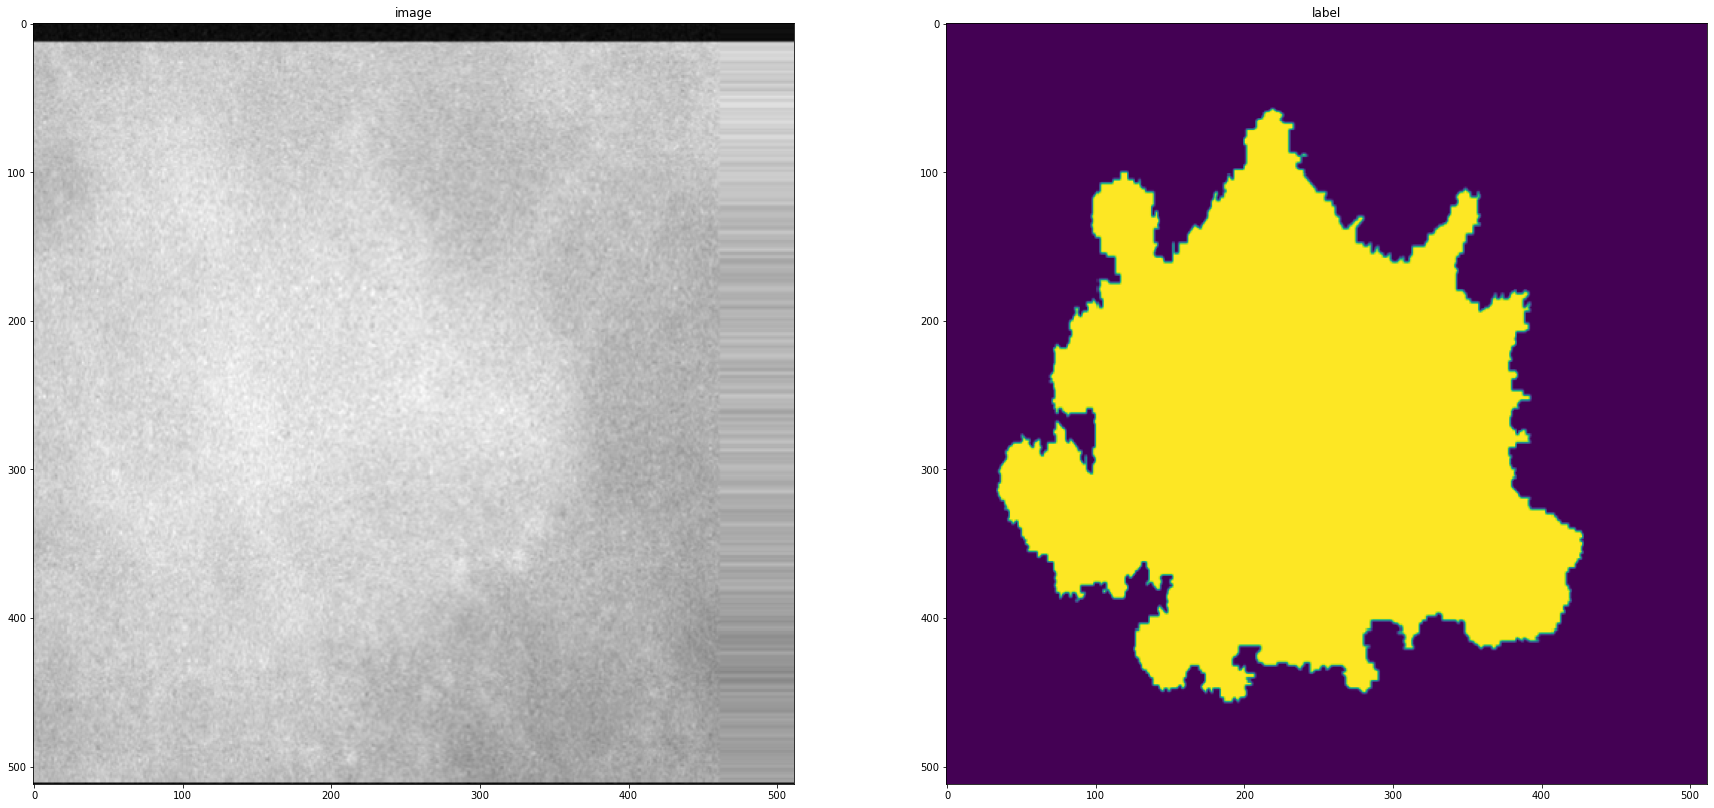

In [7]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (30, 15))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label)
plt.show()

In [8]:
np.shape(image)

torch.Size([512, 512, 1])

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [9]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

train_loader = DataLoader(train_ds, batch_size=10, shuffle=True, num_workers=4)


val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)

val_loader = DataLoader(val_ds, batch_size=5, num_workers=4)


test_ds = CacheDataset(
    data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████| 169/169 [00:01<00:00, 92.28it/s]


## Create Model, Loss, Optimizer

In [10]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:1")
# model = UNet(
#    spatial_dims=2,
#    in_channels=1,
#    out_channels=1,
#    channels=(16, 32, 64, 128, 256),
#    strides=(2, 2, 2, 2),
#    num_res_units=2,
#    norm=Norm.BATCH,
# ).to(device)

#model = MDA_Net(img_ch=1, output_ch=1).to(device) #é preciso tirar a sigmoid

model = UNETR(
   in_channels=1,
   out_channels=1,
   img_size=(512,512),
   spatial_dims=2,
).to(device)

# model = ViTAutoEnc(
#     in_channels=1,
#     img_size=(512,384,1),
#     patch_size=(512//8,384//8,1),
#     spatial_dims=3,
# ).to(device)

# automatically extracts the strides and kernels based on nnU-Net empirical rules
# spacing = (1,1)
# patch_size = (384,768)
# spacings = spacing
# sizes = patch_size
# strides, kernels = [], []
# while True:
#    spacing_ratio = [sp / min(spacings) for sp in spacings]
#    stride = [2 if ratio <= 2 and size >= 8 else 1 for (ratio, size) in zip(spacing_ratio, sizes)]
#    kernel = [3 if ratio <= 2 else 1 for ratio in spacing_ratio]
#    if all(s == 1 for s in stride):
#        break
#    sizes = [i / j for i, j in zip(sizes, stride)]
#    spacings = [i * j for i, j in zip(spacings, stride)]
#    kernels.append(kernel)
#    strides.append(stride)
# strides.insert(0, len(spacings) * [1])
# kernels.append(len(spacings) * [3])

# model = DynUNet(
#    spatial_dims=2,
#    in_channels=1,
#    out_channels=1,
#    kernel_size =kernels,
#    strides=strides,
#    upsample_kernel_size=strides,
#    deep_supervision=False
# ).to(device)
              
#loss_function = DiceLoss(sigmoid=False) #MDA_Net
loss_function = DiceCELoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")
sig = nn.Sigmoid()


In [ ]:
#np.shape(outputs[0])

# Training! Stop here

## Create root path

In [ ]:
parent_dir = "/home/users/jvilaca/raul/Methods/UNetTR/"
mes_ext = {1: 'Jan', 2 : 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',6:'Jun',7:'Jul', 8:'Aug',9:'Sep', 10: 'Oct', 11:'Nov', 12:'Dec'}
month = time.strftime("%m")
time_str = time.strftime("%d_%H-%M-%S")
filename = mes_ext[int(month)]+time_str;

path = os.path.join(parent_dir, filename)
os.mkdir(path)

root_dir = path
print(root_dir)

## Execute a typical PyTorch training process

In [ ]:
max_epochs = 5000
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
epoch_loss_values_val = []
metric_values = []

writer = SummaryWriter()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_loss_val = 0
    step = 0
    step_val = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        dims = np.shape(inputs)
        inputs = torch.reshape(inputs,[dims[0],1,dims[2],dims[3]])
        labels = torch.reshape(labels,[dims[0],1,dims[2],dims[3]])
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_function(outputs, labels)
        # loss = loss_function(outputs, torch.cat((labels,labels),2))#para dyn_net
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        
    # Loss/train
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    writer.add_scalar("Loss/train", epoch_loss,epoch+1)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                step_val += 1
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                dimsVal = np.shape(val_inputs)
                val_inputs = torch.reshape(val_inputs,[dimsVal[0],1,dimsVal[2],dimsVal[3]])
                val_labels = torch.reshape(val_labels,[dimsVal[0],1,dimsVal[2],dimsVal[3]])
                val_outputs = model(val_inputs)
                
                loss_val = loss_function(val_outputs, val_labels)
                # loss_val = loss_function(val_outputs, torch.cat((val_labels,val_labels),1))
                epoch_loss_val += loss_val.item()
                val_outputs = sig(val_outputs)
                val_outputs = torch.where(val_outputs>0.9, 1, 0)
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                
            # Loss/val
            epoch_loss_val /= step_val
            epoch_loss_values_val.append(epoch_loss_val)
            writer.add_scalar("Loss/val", epoch_loss_val,epoch+1)
            
            # Dice/val
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            writer.add_scalar("Dice/val", metric,epoch+1)
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save({'model': model.state_dict(),'epoch': epoch+1,'optimizer': optimizer.state_dict()}, os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
                
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

torch.save({'model': model.state_dict(),'epoch': epoch+1,'optimizer': optimizer.state_dict()}, os.path.join(
                    root_dir, "final_metric_model.pth"))

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

# Finished training!

## Check model output with the input image and label

In [ ]:
x = 0
model.eval()
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = (
            val_data["image"].to(device),
            val_data["label"].to(device),
        )
        dimsVal = np.shape(val_inputs)
        val_inputs = torch.reshape(val_inputs,[dimsVal[0],1,dimsVal[2],dimsVal[3]])
        val_labels = torch.reshape(val_labels,[dimsVal[0],1,dimsVal[2],dimsVal[3]])
        kk = model(val_inputs)
        kk = sig(kk)
        #kk = torch.where(kk>0.9, 1, 0)
        x = x + 1
        if (x==3):
            break

In [ ]:
kk1 = torch.where(kk>0.99, 1, 0)
a = kk1
b = val_labels
print(np.shape(a))
print(np.shape(b))

In [ ]:
dice_metric(y_pred=a, y=b)

In [ ]:
# plot the slice [:, :, 80]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title(f"image")
plt.imshow(val_inputs[0, 0, :, :].cpu().detach().numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title(f"label")
plt.imshow(val_labels[0, 0, :, :].cpu().detach().numpy(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title(f"output")
plt.imshow(kk[:, :, 0], cmap="gray") #kk
plt.show()

In [ ]:
# plot the slice [:, :, 80]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title(f"image")
plt.imshow(val_inputs[1, 0, :, :].cpu().detach().numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title(f"label")
plt.imshow(val_labels[1, 0, :, :].cpu().detach().numpy(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title(f"output")
plt.imshow(kk1[1, 0, :, :].cpu().detach().numpy(), cmap="gray") #kk1
plt.show()

# Testing!

## Load model and save prediction masks 

In [51]:
root_dir = "/home/users/jvilaca/raul/Methods/UNetTR/Dec21_11-25-12"
pathSave = root_dir + "/predLabelsTh99"
os.mkdir(pathSave)
pathSave = pathSave + "/"
pathSave

'/home/users/jvilaca/raul/Methods/UNetTR/Dec21_11-25-12/predLabelsTh99/'

In [52]:
#model_name = "final_metric_model.pth"
model_name = "best_metric_model.pth"

checkpoint = torch.load(os.path.join(root_dir , model_name))
model.load_state_dict(checkpoint['model'])

model.eval()
i = 0

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        dimsTest = np.shape(test_inputs)
        test_inputs = torch.reshape(test_inputs,[dimsTest[0],1,dimsTest[2],dimsTest[3]])
        test_labels = torch.reshape(test_labels,[dimsTest[0],1,dimsTest[2],dimsTest[3]])
        kk = model(test_inputs)
        kk = sig(kk)
        kk = torch.where(kk>0.99, 1, 0)
        kk = np.expand_dims(kk[0,0,:,:].cpu().detach().numpy(), axis = 2) 
        name = test_files[i]['image']
        masknii = nib.load(name)  
        m = masknii.affine
        header = masknii.header
        predicted = nib.Nifti1Image(kk, m, header)
        nib.save(predicted, pathSave+ '/' + name.split('/')[-1])
        i = i + 1

In [ ]:
# plot the slice [:, :, 80]
plt.figure("check", (18, 6))
plt.subplot(1, 3, 1)
plt.title(f"image")
plt.imshow(test_inputs[0, 0, :, :].cpu().detach().numpy(), cmap="gray")
plt.subplot(1, 3, 2)
plt.title(f"label")
plt.imshow(test_labels[0, 0, :, :].cpu().detach().numpy(), cmap="gray")
plt.subplot(1, 3, 3)
plt.title(f"output")
plt.imshow(kk[:, :, 0], cmap="gray")
plt.show()